In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
from transformers import T5Tokenizer,AutoTokenizer,BertTokenizer,AutoModel
import re
from sklearn.model_selection import train_test_split

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
df=pd.read_csv('/content/drive/MyDrive/data.csv')

In [81]:
df.shape

(134281, 4)

In [82]:
df['mhc'].value_counts()

,count
mhc,
QEFFIASGAAVDAIMWLFLECYDLQRATYHVGFT,10412
QEFFIASGAAVDAIMWGYFELYVIDRQTVHVGFT,6325
QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT,6317
QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT,6045
QEFFIASGAAVDAIMESSYDYFDLQKRNYHVVFT,5352
...,...
QEFFIASGAAVDAIMESGFDYYDFDRLTYHVVFT,3
QEFFIASGAAVDAIMQDYFHGYDFDRATYHVGFT,2
QEFFIASGAAVDAIMEVHFDYYSLQRETYHVVFT,2


In [87]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

In [55]:
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
print(test_data.index.max())
print(train_data.index.max())

26886
107393


In [89]:
df.count()

,0
pep,134281
logic,134281
allele,134281
mhc,134281


In [155]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [156]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [157]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [158]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [159]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)


In [160]:
pep_input_ids[0],pep_attention_mask[0]

(tensor([ 0, 14, 15, 19,  7, 15, 16, 17, 11,  4, 15,  4,  5, 11,  2,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [161]:
mhc_input_ids[100],mhc_attention_mask[100]

(tensor([ 0, 19,  5, 18, 18, 20, 18,  8,  6,  6,  5, 12,  4, 17, 11,  4, 18,  6,
         16, 18,  9, 19, 18, 13, 12,  9,  9,  7, 10, 20, 21,  4,  6, 20, 11,  2],
        device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'))

In [163]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [164]:
pep_input_ids.shape

torch.Size([134281, 39])

In [165]:
mhc_input_ids.shape

torch.Size([134281, 36])

In [166]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [167]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [168]:
mhc_input_ids[120],mhc_attention_mask[120]

(tensor([ 0, 19,  5, 18, 18, 20, 18,  8,  6,  6,  5, 12,  4, 17, 11,  4, 18,  6,
         16, 18,  9, 19, 18, 13, 12,  9,  9,  7, 10, 20, 21,  4,  6, 20, 11,  2,
          1,  1,  1], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0'))

In [169]:
X_pep = torch.stack((pep_input_ids,pep_attention_mask),dim=1).to(device)
X_mhc = torch.stack((mhc_input_ids,mhc_attention_mask),dim=1)

In [170]:
y = scores


In [171]:
y.shape

torch.Size([134281])

In [56]:
model.to(device)

EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

In [57]:
pep_dataset = TensorDataset(X_pep[:, 0], X_pep[:, 1])
batch_size = 4
data_loader = DataLoader(pep_dataset, batch_size=batch_size, shuffle=False)
model.eval()
all_embeddings_pep = []
with torch.no_grad():
    for input_ids, attention_mask in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state
        cls_embeddings = batch_embeddings[:, 0, :]
        all_embeddings_pep.append(cls_embeddings)
all_embeddings_pep = torch.cat(all_embeddings_pep, dim=0)

In [58]:
np.save('/content/drive/MyDrive/tensor_data_pep_cls_balanced.npy', all_embeddings_pep.cpu())
loaded_tensor = np.load('/content/drive/MyDrive/tensor_data_pep_cls_balanced.npy')

In [59]:
all_embeddings_pep.cpu() == loaded_tensor

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [60]:
mhc_dataset = TensorDataset(X_mhc[:, 0], X_mhc[:, 1])
batch_size = 32
data_loader = DataLoader(mhc_dataset, batch_size=batch_size, shuffle=False)
model.eval()
all_embeddings_mhc = []
with torch.no_grad():
    for input_ids, attention_mask in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state
        cls_embeddings = batch_embeddings[:, 0, :]
        all_embeddings_mhc.append(cls_embeddings)

# Combine all embeddings into a single tensor
all_embeddings_mhc = torch.cat(all_embeddings_mhc, dim=0)  # Shape: (num_samples, hidden_dim)

In [61]:
all_embeddings_mhc.shape

torch.Size([134281, 320])

In [173]:
np.save('/content/drive/MyDrive/tensor_data_mhc_cls_balanced.npy', all_embeddings_mhc.cpu())
loaded_tensor = np.load('/content/drive/MyDrive/tensor_data_mhc_cls.npy')

KeyboardInterrupt: 

In [63]:
all_embeddings_mhc.cpu() == loaded_tensor

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [174]:
pep_embeddings = torch.tensor(np.load('/content/drive/MyDrive/tensor_data_pep_cls.npy'))

In [175]:
file_path = '/content/drive/MyDrive/tensor_data_mhc_cls.npy'
mhc_embeddings = torch.tensor(np.load(file_path))

In [176]:
X = torch.stack((pep_embeddings,mhc_embeddings),dim=1)
y = scores

In [177]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [178]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [179]:
X_train.shape,X_test.shape,X_val.shape

(torch.Size([85939, 2, 320]),
 torch.Size([26857, 2, 320]),
 torch.Size([21485, 2, 320]))

In [180]:
y_train.shape,y_test.shape,y_val.shape

(torch.Size([85939]), torch.Size([26857]), torch.Size([21485]))

In [181]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1], y_val)
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],y_test)

In [182]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=128,shuffle=False)

In [183]:
class TransformerEncoder(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)


class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        attn_output = self.norm1(attn_output + query)
        ffn_output = self.ffn(attn_output)
        output = self.norm2(ffn_output + attn_output)

        return output


class SequenceModel(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, ffdim, dropout=0.1): # Add ffdim to the __init__ parameters
        super(SequenceModel, self).__init__()
        self.encoder_pep = TransformerEncoder(model_dim, num_heads, num_layers, dropout)
        self.encoder_mhc = TransformerEncoder(model_dim, num_heads, num_layers, dropout)
        self.cross_attention = CrossAttentionLayer(model_dim, num_heads, ffdim, dropout) # Use ffdim here
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, pep_cls, mhc_cls):
        pep_refined = self.encoder_pep(pep_cls.unsqueeze(1)).squeeze(1)
        mhc_refined = self.encoder_mhc(mhc_cls.unsqueeze(1)).squeeze(1)
        cross_output = self.cross_attention(pep_refined.unsqueeze(1), mhc_refined.unsqueeze(1), mhc_refined.unsqueeze(1))
        cross_output = cross_output.squeeze(1)
        x = F.relu(self.fc1(cross_output))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [184]:
torch.manual_seed(3407)

In [150]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00


In [185]:
import optuna
from optuna.trial import TrialState
import torch
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define objective function for Optuna
def objective(trial):
    # Define categorical hyperparameter suggestions
    model_dim = 320
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    num_layers = trial.suggest_categorical("num_layers", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    ffdim = trial.suggest_categorical("ffdim", [256, 512])
    lr = trial.suggest_categorical("learning_rate", [1e-4, 5e-4, 1e-3])
    weight_decay = 1e-3

    # Initialize the model, loss function, and optimizer
    model = SequenceModel(
        model_dim=model_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ffdim=ffdim,
        dropout=dropout
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(5):
    # Training loop for 1 epoch
      model.train()
      train_loss = 0
      for pep_ids, mhc_ids, scores in train_loader:
          pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
          optimizer.zero_grad()
          outputs = model(pep_ids, mhc_ids)
          loss = criterion(outputs.squeeze(), scores)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      train_loss /= len(train_loader)

      # Validation loop
      model.eval()
      val_loss = 0
      total_val_preds = []
      total_val_labels = []
      with torch.no_grad():
          for pep_ids, mhc_ids, scores in val_loader:
              pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
              outputs = model(pep_ids, mhc_ids)
              loss = criterion(outputs.squeeze(), scores)
              val_loss += loss.item()
              total_val_preds.append(outputs.cpu())
              total_val_labels.append(scores.cpu())

      val_loss /= len(val_loader)

      # Compute metrics
      total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
      total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
      val_r2 = r2_score(total_val_labels, total_val_preds)
      val_mse = mean_squared_error(total_val_labels, total_val_preds)
      val_rmse = np.sqrt(val_mse)
      val_mae = mean_absolute_error(total_val_labels, total_val_preds)

      print(f"Trial Results: Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}, Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")

    # Optuna minimizes the objective, so return negative R^2 to maximize it
    return val_loss

# Create and run the Optuna study
study = optuna.create_study(direction="minimize")  # Set direction to "maximize" since we want to maximize R^2
study.optimize(objective, n_trials=20)

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  Val R^2: {-trial.value:.4f}")
print(f"  Hyperparameters: {trial.params}")

# Save the best hyperparameters to a file or dictionary if needed
best_hyperparams = trial.params


[I 2025-01-18 17:06:04,342] A new study created in memory with name: no-name-e5edaf4b-fa65-406f-a9d8-c5ebf2e6b784


Trial Results: Val Loss: 0.0567, Val R^2: 0.1735, Val MSE: 0.0567, Val RMSE: 0.2381, Val MAE: 0.1957
Trial Results: Val Loss: 0.0546, Val R^2: 0.2036, Val MSE: 0.0546, Val RMSE: 0.2337, Val MAE: 0.1925
Trial Results: Val Loss: 0.0550, Val R^2: 0.1974, Val MSE: 0.0550, Val RMSE: 0.2346, Val MAE: 0.1915
Trial Results: Val Loss: 0.0537, Val R^2: 0.2176, Val MSE: 0.0537, Val RMSE: 0.2316, Val MAE: 0.1892


[I 2025-01-18 17:07:22,952] Trial 0 finished with value: 0.053564518446191436 and parameters: {'num_heads': 4, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 512, 'learning_rate': 0.0005}. Best is trial 0 with value: 0.053564518446191436.


Trial Results: Val Loss: 0.0536, Val R^2: 0.2189, Val MSE: 0.0536, Val RMSE: 0.2315, Val MAE: 0.1904
Trial Results: Val Loss: 0.0687, Val R^2: -0.0016, Val MSE: 0.0687, Val RMSE: 0.2621, Val MAE: 0.2196
Trial Results: Val Loss: 0.0687, Val R^2: -0.0010, Val MSE: 0.0687, Val RMSE: 0.2620, Val MAE: 0.2195
Trial Results: Val Loss: 0.0711, Val R^2: -0.0374, Val MSE: 0.0711, Val RMSE: 0.2667, Val MAE: 0.2244
Trial Results: Val Loss: 0.0686, Val R^2: -0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2192


[I 2025-01-18 17:09:02,451] Trial 1 finished with value: 0.06862441024609975 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 256, 'learning_rate': 0.001}. Best is trial 0 with value: 0.053564518446191436.


Trial Results: Val Loss: 0.0686, Val R^2: -0.0006, Val MSE: 0.0686, Val RMSE: 0.2620, Val MAE: 0.2194
Trial Results: Val Loss: 0.0508, Val R^2: 0.2588, Val MSE: 0.0508, Val RMSE: 0.2255, Val MAE: 0.1830
Trial Results: Val Loss: 0.0469, Val R^2: 0.3159, Val MSE: 0.0469, Val RMSE: 0.2166, Val MAE: 0.1743
Trial Results: Val Loss: 0.0485, Val R^2: 0.2932, Val MSE: 0.0485, Val RMSE: 0.2202, Val MAE: 0.1767
Trial Results: Val Loss: 0.0441, Val R^2: 0.3571, Val MSE: 0.0441, Val RMSE: 0.2100, Val MAE: 0.1678


[I 2025-01-18 17:10:21,051] Trial 2 finished with value: 0.04684372530097053 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 2 with value: 0.04684372530097053.


Trial Results: Val Loss: 0.0468, Val R^2: 0.3169, Val MSE: 0.0468, Val RMSE: 0.2164, Val MAE: 0.1716
Trial Results: Val Loss: 0.0686, Val R^2: -0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2192
Trial Results: Val Loss: 0.0687, Val R^2: -0.0015, Val MSE: 0.0687, Val RMSE: 0.2621, Val MAE: 0.2196
Trial Results: Val Loss: 0.0696, Val R^2: -0.0152, Val MSE: 0.0696, Val RMSE: 0.2639, Val MAE: 0.2216
Trial Results: Val Loss: 0.0688, Val R^2: -0.0030, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2199


[I 2025-01-18 17:12:00,157] Trial 3 finished with value: 0.06869174444693185 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.001}. Best is trial 2 with value: 0.04684372530097053.


Trial Results: Val Loss: 0.0687, Val R^2: -0.0016, Val MSE: 0.0687, Val RMSE: 0.2621, Val MAE: 0.2196
Trial Results: Val Loss: 0.0530, Val R^2: 0.2276, Val MSE: 0.0530, Val RMSE: 0.2302, Val MAE: 0.1856
Trial Results: Val Loss: 0.0489, Val R^2: 0.2866, Val MSE: 0.0489, Val RMSE: 0.2212, Val MAE: 0.1777
Trial Results: Val Loss: 0.0492, Val R^2: 0.2824, Val MSE: 0.0492, Val RMSE: 0.2218, Val MAE: 0.1788
Trial Results: Val Loss: 0.0475, Val R^2: 0.3072, Val MSE: 0.0475, Val RMSE: 0.2180, Val MAE: 0.1767


[I 2025-01-18 17:13:38,478] Trial 4 finished with value: 0.04827826802751848 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.0001}. Best is trial 2 with value: 0.04684372530097053.


Trial Results: Val Loss: 0.0483, Val R^2: 0.2960, Val MSE: 0.0483, Val RMSE: 0.2197, Val MAE: 0.1769
Trial Results: Val Loss: 0.0488, Val R^2: 0.2882, Val MSE: 0.0488, Val RMSE: 0.2209, Val MAE: 0.1790
Trial Results: Val Loss: 0.0479, Val R^2: 0.3011, Val MSE: 0.0479, Val RMSE: 0.2189, Val MAE: 0.1740
Trial Results: Val Loss: 0.0446, Val R^2: 0.3496, Val MSE: 0.0446, Val RMSE: 0.2112, Val MAE: 0.1678
Trial Results: Val Loss: 0.0444, Val R^2: 0.3530, Val MSE: 0.0444, Val RMSE: 0.2106, Val MAE: 0.1683


[I 2025-01-18 17:14:58,056] Trial 5 finished with value: 0.04111901145162327 and parameters: {'num_heads': 4, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 5 with value: 0.04111901145162327.


Trial Results: Val Loss: 0.0411, Val R^2: 0.4004, Val MSE: 0.0411, Val RMSE: 0.2028, Val MAE: 0.1615
Trial Results: Val Loss: 0.0527, Val R^2: 0.2311, Val MSE: 0.0527, Val RMSE: 0.2296, Val MAE: 0.1858
Trial Results: Val Loss: 0.0483, Val R^2: 0.2954, Val MSE: 0.0483, Val RMSE: 0.2198, Val MAE: 0.1780
Trial Results: Val Loss: 0.0475, Val R^2: 0.3073, Val MSE: 0.0475, Val RMSE: 0.2180, Val MAE: 0.1756
Trial Results: Val Loss: 0.0478, Val R^2: 0.3032, Val MSE: 0.0478, Val RMSE: 0.2186, Val MAE: 0.1767


[I 2025-01-18 17:16:17,406] Trial 6 finished with value: 0.04460078950173089 and parameters: {'num_heads': 4, 'num_layers': 3, 'dropout': 0.3, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 5 with value: 0.04111901145162327.


Trial Results: Val Loss: 0.0446, Val R^2: 0.3497, Val MSE: 0.0446, Val RMSE: 0.2112, Val MAE: 0.1691
Trial Results: Val Loss: 0.0632, Val R^2: 0.0788, Val MSE: 0.0632, Val RMSE: 0.2513, Val MAE: 0.2043
Trial Results: Val Loss: 0.0544, Val R^2: 0.2073, Val MSE: 0.0544, Val RMSE: 0.2332, Val MAE: 0.1921
Trial Results: Val Loss: 0.0579, Val R^2: 0.1552, Val MSE: 0.0579, Val RMSE: 0.2407, Val MAE: 0.1956
Trial Results: Val Loss: 0.0565, Val R^2: 0.1767, Val MSE: 0.0565, Val RMSE: 0.2376, Val MAE: 0.1958


[I 2025-01-18 17:17:17,739] Trial 7 finished with value: 0.05756390440676894 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.001}. Best is trial 5 with value: 0.04111901145162327.


Trial Results: Val Loss: 0.0576, Val R^2: 0.1606, Val MSE: 0.0576, Val RMSE: 0.2399, Val MAE: 0.1937
Trial Results: Val Loss: 0.0494, Val R^2: 0.2792, Val MSE: 0.0494, Val RMSE: 0.2223, Val MAE: 0.1792
Trial Results: Val Loss: 0.0470, Val R^2: 0.3143, Val MSE: 0.0470, Val RMSE: 0.2169, Val MAE: 0.1742
Trial Results: Val Loss: 0.0448, Val R^2: 0.3468, Val MSE: 0.0448, Val RMSE: 0.2117, Val MAE: 0.1711
Trial Results: Val Loss: 0.0439, Val R^2: 0.3606, Val MSE: 0.0439, Val RMSE: 0.2094, Val MAE: 0.1676


[I 2025-01-18 17:18:38,034] Trial 8 finished with value: 0.0432257491518699 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001}. Best is trial 5 with value: 0.04111901145162327.


Trial Results: Val Loss: 0.0432, Val R^2: 0.3697, Val MSE: 0.0432, Val RMSE: 0.2079, Val MAE: 0.1650
Trial Results: Val Loss: 0.0612, Val R^2: 0.1070, Val MSE: 0.0612, Val RMSE: 0.2475, Val MAE: 0.2043
Trial Results: Val Loss: 0.0540, Val R^2: 0.2123, Val MSE: 0.0540, Val RMSE: 0.2324, Val MAE: 0.1902
Trial Results: Val Loss: 0.0557, Val R^2: 0.1881, Val MSE: 0.0557, Val RMSE: 0.2360, Val MAE: 0.1914
Trial Results: Val Loss: 0.0534, Val R^2: 0.2214, Val MSE: 0.0534, Val RMSE: 0.2311, Val MAE: 0.1897


[I 2025-01-18 17:19:57,768] Trial 9 finished with value: 0.05287533798920257 and parameters: {'num_heads': 4, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 512, 'learning_rate': 0.0005}. Best is trial 5 with value: 0.04111901145162327.


Trial Results: Val Loss: 0.0529, Val R^2: 0.2289, Val MSE: 0.0529, Val RMSE: 0.2300, Val MAE: 0.1882
Trial Results: Val Loss: 0.0500, Val R^2: 0.2712, Val MSE: 0.0500, Val RMSE: 0.2236, Val MAE: 0.1807
Trial Results: Val Loss: 0.0453, Val R^2: 0.3388, Val MSE: 0.0453, Val RMSE: 0.2129, Val MAE: 0.1709
Trial Results: Val Loss: 0.0434, Val R^2: 0.3677, Val MSE: 0.0434, Val RMSE: 0.2082, Val MAE: 0.1662
Trial Results: Val Loss: 0.0418, Val R^2: 0.3907, Val MSE: 0.0418, Val RMSE: 0.2044, Val MAE: 0.1631


[I 2025-01-18 17:20:58,071] Trial 10 finished with value: 0.042310625669502076 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 5 with value: 0.04111901145162327.


Trial Results: Val Loss: 0.0423, Val R^2: 0.3830, Val MSE: 0.0423, Val RMSE: 0.2057, Val MAE: 0.1640
Trial Results: Val Loss: 0.0489, Val R^2: 0.2863, Val MSE: 0.0489, Val RMSE: 0.2212, Val MAE: 0.1801
Trial Results: Val Loss: 0.0452, Val R^2: 0.3409, Val MSE: 0.0452, Val RMSE: 0.2126, Val MAE: 0.1725
Trial Results: Val Loss: 0.0430, Val R^2: 0.3735, Val MSE: 0.0430, Val RMSE: 0.2073, Val MAE: 0.1660
Trial Results: Val Loss: 0.0436, Val R^2: 0.3644, Val MSE: 0.0436, Val RMSE: 0.2088, Val MAE: 0.1681


[I 2025-01-18 17:21:58,476] Trial 11 finished with value: 0.04101550230933797 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 11 with value: 0.04101550230933797.


Trial Results: Val Loss: 0.0410, Val R^2: 0.4020, Val MSE: 0.0410, Val RMSE: 0.2025, Val MAE: 0.1613
Trial Results: Val Loss: 0.0477, Val R^2: 0.3044, Val MSE: 0.0477, Val RMSE: 0.2184, Val MAE: 0.1782
Trial Results: Val Loss: 0.0446, Val R^2: 0.3498, Val MSE: 0.0446, Val RMSE: 0.2112, Val MAE: 0.1702
Trial Results: Val Loss: 0.0445, Val R^2: 0.3509, Val MSE: 0.0445, Val RMSE: 0.2110, Val MAE: 0.1689
Trial Results: Val Loss: 0.0427, Val R^2: 0.3771, Val MSE: 0.0427, Val RMSE: 0.2067, Val MAE: 0.1641


[I 2025-01-18 17:22:59,372] Trial 12 finished with value: 0.04135949577071837 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 11 with value: 0.04101550230933797.


Trial Results: Val Loss: 0.0414, Val R^2: 0.3969, Val MSE: 0.0414, Val RMSE: 0.2034, Val MAE: 0.1625
Trial Results: Val Loss: 0.0481, Val R^2: 0.2987, Val MSE: 0.0481, Val RMSE: 0.2193, Val MAE: 0.1765
Trial Results: Val Loss: 0.0452, Val R^2: 0.3415, Val MSE: 0.0452, Val RMSE: 0.2125, Val MAE: 0.1707
Trial Results: Val Loss: 0.0431, Val R^2: 0.3714, Val MSE: 0.0431, Val RMSE: 0.2076, Val MAE: 0.1666
Trial Results: Val Loss: 0.0421, Val R^2: 0.3868, Val MSE: 0.0421, Val RMSE: 0.2051, Val MAE: 0.1635


[I 2025-01-18 17:23:59,330] Trial 13 finished with value: 0.04052177966306252 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0405, Val R^2: 0.4091, Val MSE: 0.0405, Val RMSE: 0.2013, Val MAE: 0.1585
Trial Results: Val Loss: 0.0465, Val R^2: 0.3221, Val MSE: 0.0465, Val RMSE: 0.2156, Val MAE: 0.1738
Trial Results: Val Loss: 0.0441, Val R^2: 0.3572, Val MSE: 0.0441, Val RMSE: 0.2100, Val MAE: 0.1685
Trial Results: Val Loss: 0.0431, Val R^2: 0.3717, Val MSE: 0.0431, Val RMSE: 0.2076, Val MAE: 0.1671
Trial Results: Val Loss: 0.0424, Val R^2: 0.3817, Val MSE: 0.0424, Val RMSE: 0.2059, Val MAE: 0.1638


[I 2025-01-18 17:25:00,974] Trial 14 finished with value: 0.04203947462762395 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0420, Val R^2: 0.3870, Val MSE: 0.0420, Val RMSE: 0.2050, Val MAE: 0.1624
Trial Results: Val Loss: 0.0519, Val R^2: 0.2436, Val MSE: 0.0519, Val RMSE: 0.2278, Val MAE: 0.1863
Trial Results: Val Loss: 0.0474, Val R^2: 0.3089, Val MSE: 0.0474, Val RMSE: 0.2177, Val MAE: 0.1765
Trial Results: Val Loss: 0.0474, Val R^2: 0.3095, Val MSE: 0.0474, Val RMSE: 0.2176, Val MAE: 0.1755
Trial Results: Val Loss: 0.0463, Val R^2: 0.3246, Val MSE: 0.0463, Val RMSE: 0.2152, Val MAE: 0.1732


[I 2025-01-18 17:26:00,840] Trial 15 finished with value: 0.04896291345357895 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0005}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0490, Val R^2: 0.2860, Val MSE: 0.0490, Val RMSE: 0.2213, Val MAE: 0.1794
Trial Results: Val Loss: 0.0468, Val R^2: 0.3177, Val MSE: 0.0468, Val RMSE: 0.2163, Val MAE: 0.1750
Trial Results: Val Loss: 0.0468, Val R^2: 0.3179, Val MSE: 0.0468, Val RMSE: 0.2163, Val MAE: 0.1742
Trial Results: Val Loss: 0.0433, Val R^2: 0.3689, Val MSE: 0.0433, Val RMSE: 0.2080, Val MAE: 0.1669
Trial Results: Val Loss: 0.0417, Val R^2: 0.3919, Val MSE: 0.0417, Val RMSE: 0.2042, Val MAE: 0.1622


[I 2025-01-18 17:27:01,456] Trial 16 finished with value: 0.04104604384684492 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0410, Val R^2: 0.4015, Val MSE: 0.0410, Val RMSE: 0.2026, Val MAE: 0.1593
Trial Results: Val Loss: 0.0496, Val R^2: 0.2769, Val MSE: 0.0496, Val RMSE: 0.2227, Val MAE: 0.1797
Trial Results: Val Loss: 0.0459, Val R^2: 0.3312, Val MSE: 0.0459, Val RMSE: 0.2142, Val MAE: 0.1720
Trial Results: Val Loss: 0.0443, Val R^2: 0.3541, Val MSE: 0.0443, Val RMSE: 0.2105, Val MAE: 0.1679
Trial Results: Val Loss: 0.0437, Val R^2: 0.3627, Val MSE: 0.0437, Val RMSE: 0.2091, Val MAE: 0.1666


[I 2025-01-18 17:28:04,773] Trial 17 finished with value: 0.04212235054001212 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0421, Val R^2: 0.3858, Val MSE: 0.0421, Val RMSE: 0.2052, Val MAE: 0.1638
Trial Results: Val Loss: 0.0523, Val R^2: 0.2371, Val MSE: 0.0523, Val RMSE: 0.2287, Val MAE: 0.1879
Trial Results: Val Loss: 0.0486, Val R^2: 0.2919, Val MSE: 0.0486, Val RMSE: 0.2204, Val MAE: 0.1789
Trial Results: Val Loss: 0.0491, Val R^2: 0.2834, Val MSE: 0.0491, Val RMSE: 0.2217, Val MAE: 0.1816
Trial Results: Val Loss: 0.0463, Val R^2: 0.3242, Val MSE: 0.0464, Val RMSE: 0.2153, Val MAE: 0.1747


[I 2025-01-18 17:29:05,554] Trial 18 finished with value: 0.04575921754751887 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0005}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0458, Val R^2: 0.3328, Val MSE: 0.0458, Val RMSE: 0.2139, Val MAE: 0.1710
Trial Results: Val Loss: 0.0680, Val R^2: 0.0081, Val MSE: 0.0680, Val RMSE: 0.2608, Val MAE: 0.2151
Trial Results: Val Loss: 0.0560, Val R^2: 0.1838, Val MSE: 0.0560, Val RMSE: 0.2366, Val MAE: 0.1942
Trial Results: Val Loss: 0.0545, Val R^2: 0.2059, Val MSE: 0.0545, Val RMSE: 0.2334, Val MAE: 0.1905
Trial Results: Val Loss: 0.0511, Val R^2: 0.2552, Val MSE: 0.0511, Val RMSE: 0.2260, Val MAE: 0.1845


[I 2025-01-18 17:30:05,883] Trial 19 finished with value: 0.05033090976732118 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.001}. Best is trial 13 with value: 0.04052177966306252.


Trial Results: Val Loss: 0.0503, Val R^2: 0.2660, Val MSE: 0.0503, Val RMSE: 0.2244, Val MAE: 0.1844
Best trial:
  Val R^2: -0.0405
  Hyperparameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001}


In [186]:
model_dim = 320
num_heads = 8
num_layers = 2
dropout = 0.1
ffdim = 256
model = SequenceModel(model_dim, num_heads, num_layers,ffdim,dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4 ,weight_decay=1e-3)
epochs = 200

In [187]:
model.to(device)

SequenceModel(
  (encoder_pep): TransformerEncoder(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
      )
      (linear1): Linear(in_features=320, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=320, bias=True)
      (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
          )
          (linear1): Linear(in_features=320, out_fea

In [188]:
patience = 15
best_val_r2 = 0
patience_counter = 0
save_path = '/content/drive/MyDrive/pepesmcls.pth'
train_losses = []
val_losses = []
val_r2_list = []
train_mse_list = []
val_mse_list = []
train_rmse_list = []
val_rmse_list = []
train_mae_list = []
val_mae_list = []
train_r2_list = []

for epoch in range(epochs):
    # train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids, scores in train_loader:
        pep_ids,  mhc_ids, scores = pep_ids.to(device),mhc_ids.to(device),scores.to(device)
        optimizer.zero_grad()
        outputs = model(pep_ids,  mhc_ids)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(outputs.detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds, dim=0).numpy().flatten()
    total_train_labels = torch.cat(total_train_labels, dim=0).numpy().flatten()
    train_r2 = r2_score(total_train_labels, total_train_preds)
    train_mse = mean_squared_error(total_train_labels, total_train_preds)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(total_train_labels, total_train_preds)

    train_r2_list.append(train_r2)
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train R^2: {train_r2:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

    # val loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, scores in val_loader:
            pep_ids, mhc_ids, scores = (
                pep_ids.to(device),
                mhc_ids.to(device),
                scores.to(device)
            )
            outputs = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            val_loss += loss.item()
            total_val_preds.append(outputs.cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
    total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
    val_r2 = r2_score(total_val_labels, total_val_preds)
    val_mse = mean_squared_error(total_val_labels, total_val_preds)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(total_val_labels, total_val_preds)

    val_r2_list.append(val_r2)
    val_mse_list.append(val_mse)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f} ,Val R^2: {val_r2:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"best model saved and r2: {best_val_r2:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"earlystop at epoch {epoch+1}. Best val r2: {best_val_r2:.4f}")


Epoch 1, Train Loss: 0.0548, Train R^2: 0.1979, MSE: 0.0548, RMSE: 0.2342, MAE: 0.1912
Epoch 1, Val Loss: 0.0482 ,Val R^2: 0.2972, MSE: 0.0482, RMSE: 0.2195, MAE: 0.1790
best model saved and r2: 0.2972
Epoch 2, Train Loss: 0.0470, Train R^2: 0.3126, MSE: 0.0470, RMSE: 0.2168, MAE: 0.1752
Epoch 2, Val Loss: 0.0456 ,Val R^2: 0.3353, MSE: 0.0456, RMSE: 0.2135, MAE: 0.1721
best model saved and r2: 0.3353
Epoch 3, Train Loss: 0.0447, Train R^2: 0.3458, MSE: 0.0447, RMSE: 0.2115, MAE: 0.1700
Epoch 3, Val Loss: 0.0442 ,Val R^2: 0.3552, MSE: 0.0442, RMSE: 0.2103, MAE: 0.1670
best model saved and r2: 0.3552
Epoch 4, Train Loss: 0.0430, Train R^2: 0.3709, MSE: 0.0430, RMSE: 0.2074, MAE: 0.1661
Epoch 4, Val Loss: 0.0425 ,Val R^2: 0.3798, MSE: 0.0425, RMSE: 0.2062, MAE: 0.1632
best model saved and r2: 0.3798
Epoch 5, Train Loss: 0.0415, Train R^2: 0.3930, MSE: 0.0415, RMSE: 0.2037, MAE: 0.1626
Epoch 5, Val Loss: 0.0418 ,Val R^2: 0.3900, MSE: 0.0418, RMSE: 0.2045, MAE: 0.1633
best model saved and r

KeyboardInterrupt: 

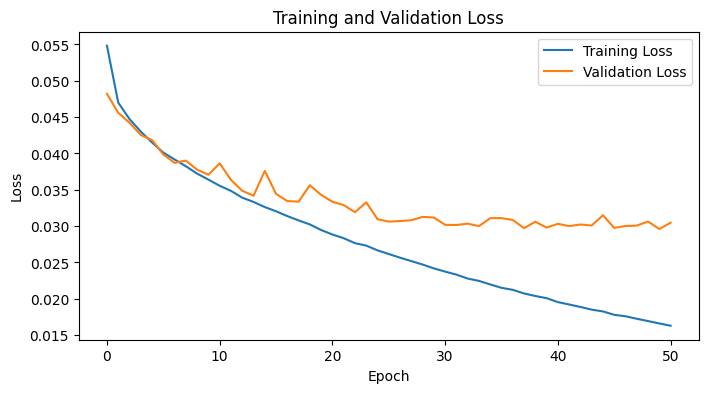

In [189]:
plt.figure(figsize=(8,4))
plt.plot(train_losses[:51], label='Training Loss')
plt.plot(val_losses[:51], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

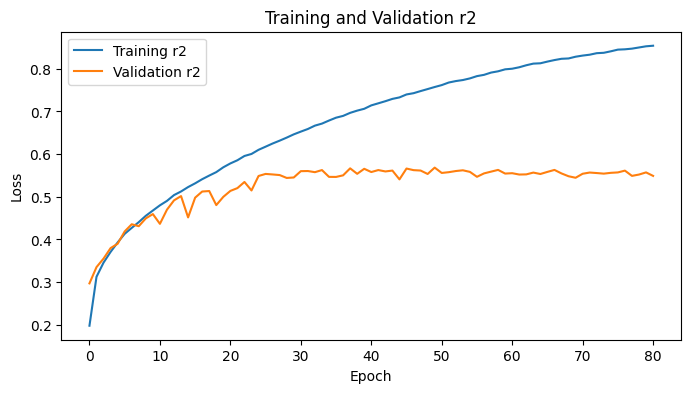

In [190]:
plt.figure(figsize=(8, 4))
plt.plot(train_r2_list[:131], label='Training r2')
plt.plot(val_r2_list[:131], label='Validation r2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation r2')
plt.legend()

Load best Model

In [194]:
model_dim = 320
num_heads = 8
num_layers = 2
dropout = 0.1
max_len = 39
ffdim = 256
model = SequenceModel(model_dim, num_heads, num_layers,ffdim,dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4 ,weight_decay=1e-3)

model.load_state_dict(torch.load('/content/drive/MyDrive/pepesmcls05684.pth'))

<ipython-input-194-9abd393c787d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/pepesmcls05684.pth'))


<All keys matched successfully>

Train Loss: 0.0120
Train R^2: 0.8247
Train MSE: 0.0120
Train MAE: 0.0841
Train RMSE: 0.2899


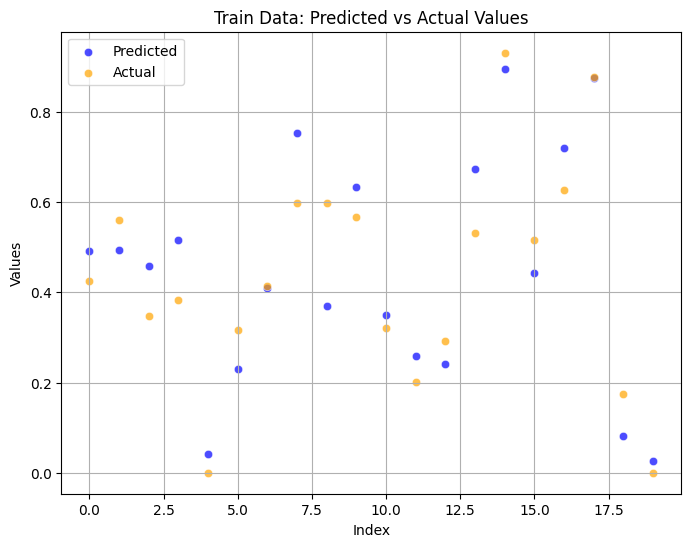

In [195]:
model.eval()
train_loss = 0
train_scores = []
train_predictions = []

with torch.no_grad():
    for pep_ids,mhc_ids, scores in train_loader:
        # Move tensors to the appropriate device
        pep_ids,mhc_ids, scores=pep_ids.to(device),mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids,mhc_ids)

        # Append labels and predictions to lists
        train_scores.extend(scores.cpu().numpy())
        train_predictions.extend(outputs.cpu().numpy().flatten())

        # Compute loss
        loss = criterion(outputs.squeeze(), scores)
        train_loss += loss.item()

# Compute average test loss
train_loss /= len(train_loader)

# Convert lists to numpy arrays
train_scores = np.array(train_scores)
train_predictions = np.array(train_predictions)
train_mse = mean_squared_error(train_scores,train_predictions)
train_mae = mean_absolute_error(train_scores,train_predictions)
train_rmse = np.sqrt(train_mae)

# Calculate R^2
train_r2 = r2_score(train_scores, train_predictions)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")

train_data = pd.DataFrame({
    'Index': np.arange(len(train_predictions[:20])),
    'Predicted': train_predictions[:20],
    'Actual': train_scores[:20]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=train_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Train Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

validation Loss: 0.0296
validation R^2: 0.5684
validation MSE: 0.0296
validation MAE: 0.1296
validation RMSE: 0.3600


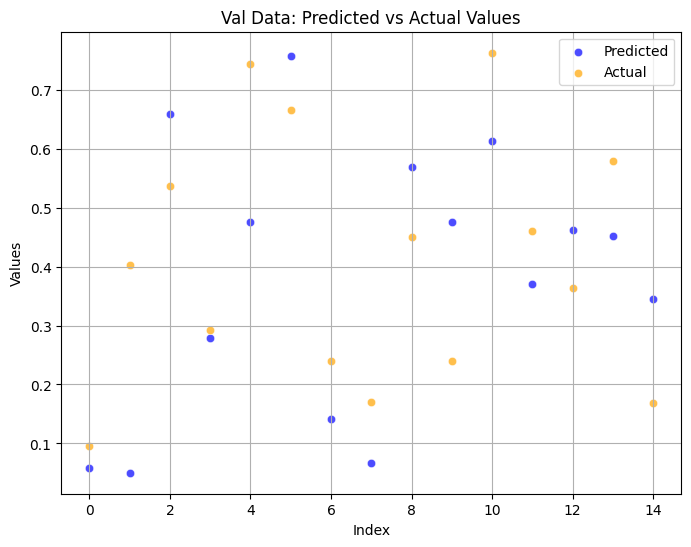

In [198]:
model.eval()
validation_loss = 0
validation_scores = []
validation_predictions = []

with torch.no_grad():
    for pep_ids,mhc_ids, scores in val_loader:
        # Move tensors to the appropriate device
        pep_ids,mhc_ids, scores=pep_ids.to(device),mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids,mhc_ids)

        # Append labels and predictions to lists
        validation_scores.extend(scores.cpu().numpy())
        validation_predictions.extend(outputs.cpu().numpy().flatten())

        # Compute loss
        loss = criterion(outputs.squeeze(), scores)
        validation_loss += loss.item()

validation_loss /= len(val_loader)

# Convert lists to numpy arrays
validation_scores = np.array(validation_scores)
validation_predictions = np.array(validation_predictions)
validation_mse = mean_squared_error(validation_scores,validation_predictions)
validation_mae = mean_absolute_error(validation_scores,validation_predictions)
validation_rmse = np.sqrt(validation_mae)

# Calculate R^2
validation_r2 = r2_score(validation_scores, validation_predictions)
print(f"validation Loss: {validation_loss:.4f}")
print(f"validation R^2: {validation_r2:.4f}")
print(f"validation MSE: {validation_mse:.4f}")
print(f"validation MAE: {validation_mae:.4f}")
print(f"validation RMSE: {validation_rmse:.4f}")

val_data = pd.DataFrame({
    'Index': np.arange(len(validation_predictions[:15])),
    'Predicted': validation_predictions[:15],
    'Actual': validation_scores[:15]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=val_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=val_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Val Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


Test Loss: 0.0290
Test R^2: 0.5783
Test MSE: 0.0290
Test MAE: 0.1280
Test RMSE: 0.3578


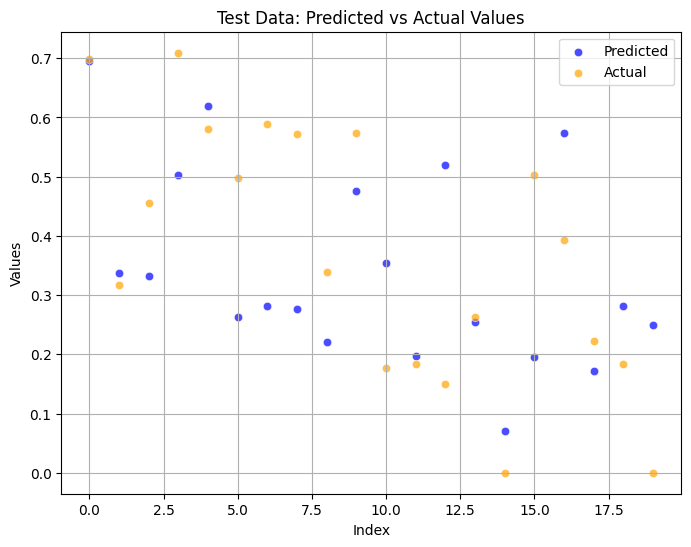

In [199]:
# Set the model to evaluation mode
model.eval()
test_loss = 0
test_scores = []
test_predictions = []

with torch.no_grad():
    for pep_ids, mhc_ids, scores in test_loader:
        # Move tensors to the appropriate device
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids, mhc_ids)

        # Append labels and predictions to lists
        test_scores.extend(scores.cpu().numpy())
        test_predictions.extend(outputs.cpu().numpy().flatten())

        # Compute loss
        loss = criterion(outputs.squeeze(), scores)
        test_loss += loss.item()

# Compute average test loss
test_loss /= len(test_loader)

# Convert lists to numpy arrays
test_scores = np.array(test_scores)
test_predictions = np.array(test_predictions)
test_mse = mean_squared_error(test_scores, test_predictions)
test_mae = mean_absolute_error(test_scores, test_predictions)
test_rmse = np.sqrt(test_mae)

# Calculate R^2
test_r2 = r2_score(test_scores, test_predictions)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Plotting Predicted vs Actual Values
test_data = pd.DataFrame({
    'Index': np.arange(len(test_predictions[:20])),
    'Predicted': test_predictions[:20],
    'Actual': test_scores[:20]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=test_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=test_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Test Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


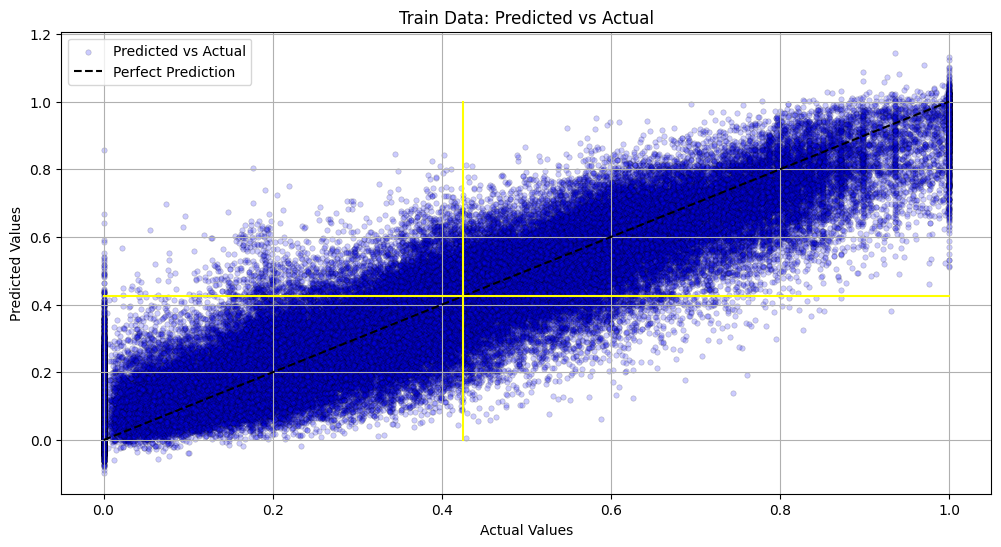

In [222]:
train_data = pd.DataFrame({
    'Predicted': train_predictions,
    'Actual': train_scores
})
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train_data['Actual'], y=train_data['Predicted'], color='blue', s=15, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(train_data['Actual']), max(train_data['Actual'])], [min(train_data['Actual']), max(train_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='yellow',)
plt.plot([0,1],[0.4256,0.4256],color='yellow')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Train Data: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

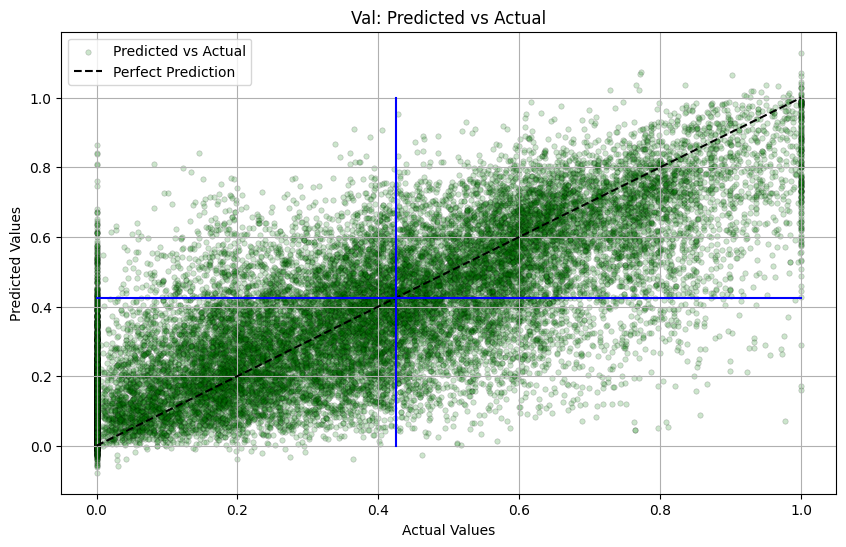

In [225]:
val_data = pd.DataFrame({
    'Predicted':validation_predictions,
    'Actual': validation_scores
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_data['Actual'], y=val_data['Predicted'], color='green', s=15, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(val_data['Actual']), max(val_data['Actual'])], [min(val_data['Actual']), max(val_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Val: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

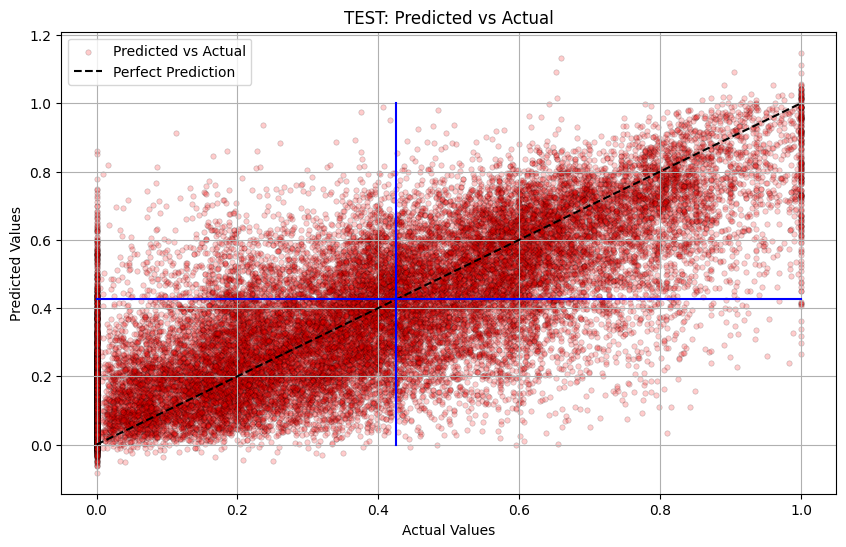

In [227]:
test_data = pd.DataFrame({
    'Predicted':test_predictions,
    'Actual': test_scores
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=15, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
threshold = 0.4256

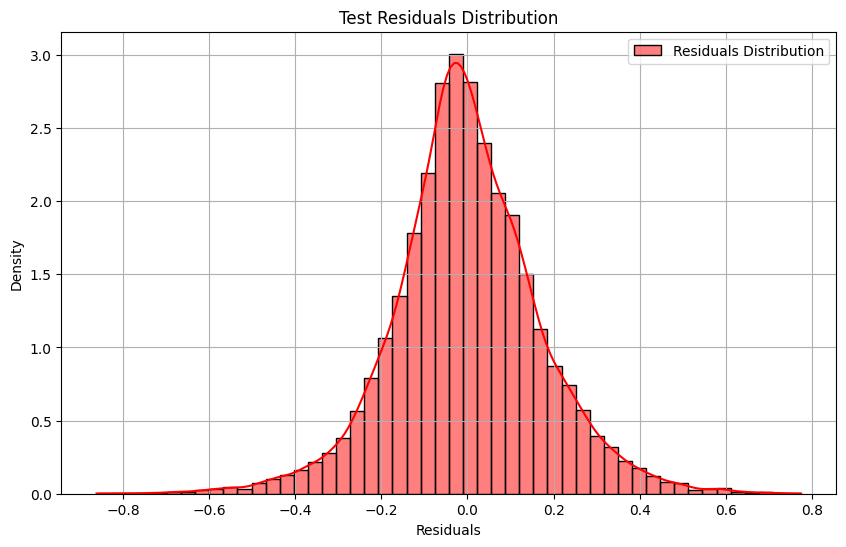

In [213]:
residuals = test_scores - test_predictions
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

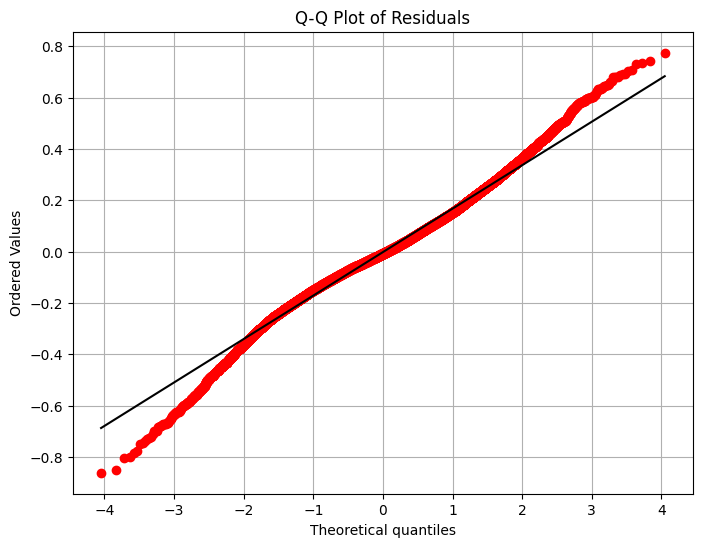

In [216]:
from scipy.stats import probplot

plt.figure(figsize=(8, 6))
qq_plot = probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('black')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Visualize attention weights
def plot_attention_weights(attn_weights, pep_sequence, mhc_sequence):
    """
    Plots attention weights from the cross-attention layer.

    Args:
        attn_weights: Attention weights tensor (shape: [batch_size, query_len, key_len]).
        pep_sequence: List of peptide sequence tokens.
        mhc_sequence: List of MHC sequence tokens.
    """
    attn_weights = attn_weights.squeeze(0).detach().cpu().numpy()  # Shape: [query_len, key_len]
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_weights, xticklabels=mhc_sequence, yticklabels=pep_sequence, cmap='viridis', cbar=True)
    plt.xlabel("MHC Sequence Tokens")
    plt.ylabel("Peptide Sequence Tokens")
    plt.title("Cross-Attention Weights")
    plt.show()

# Assuming `attn_weights` is obtained from the forward pass of the model
model = SequenceModel(model_dim=128, num_heads=4, num_layers=2, ff_dim=256)
pep_cls = torch.rand(32, 128)  # Example peptide input
mhc_cls = torch.rand(32, 128)  # Example MHC input

output, attn_weights = model(pep_cls, mhc_cls)

# Define dummy sequences for labels
pep_sequence = [f"P{i}" for i in range(pep_cls.size(1))]
mhc_sequence = [f"M{i}" for i in range(mhc_cls.size(1))]

# Plot attention weights
plot_attention_weights(attn_weights, pep_sequence, mhc_sequence)